In [16]:
import os
import tensorflow as tf
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from keras import layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from sklearn.neighbors import NearestNeighbors

In [17]:
def load_image(image_path):
    try:
        img = Image.open(image_path).convert('RGB')  # Convertir todas las imágenes a modo RGB
        img = img.resize((256, 256))  # Redimensionar las imágenes a 256x256 píxeles
        img = np.array(img)
        return img
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

def load_dataset(data_dir):
    images = []
    labels = []
    image_paths = []
    label_names = sorted(os.listdir(data_dir))
    label_map = {label_name: idx for idx, label_name in enumerate(label_names)}
    
    for label_name in label_names:
        label_dir = os.path.join(data_dir, label_name)
        if os.path.isdir(label_dir):
            for file_name in os.listdir(label_dir):
                if file_name.endswith(('.jpg', '.jpeg', '.png')):
                    image_path = os.path.join(label_dir, file_name)
                    img = load_image(image_path)
                    if img is not None:
                        images.append(img)
                        labels.append(label_map[label_name])
                        image_paths.append(image_path)
                    
    images = np.array(images)
    labels = np.array(labels)
    return images, labels, label_map, image_paths

In [18]:
data_dir = '101_ObjectCategories'
images, labels, label_map, image_paths = load_dataset(data_dir)
train_images, test_images, train_labels, test_labels, train_paths, test_paths = train_test_split(images, labels, image_paths, train_size=0.8, stratify=labels)

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

dataset_info = {
    'description': 'Caltech101 dataset manually loaded',
    'features': {
        'image': {'shape': (256, 256, 3), 'dtype': 'uint8'},
        'label': {'num_classes': len(label_map), 'names': list(label_map.keys())}
    },
    'num_examples': len(images),
    'splits': {
        'train': {'num_examples': len(train_images)},
        'test': {'num_examples': len(test_images)}
    }
}

num_classes = dataset_info['features']['label']['num_classes']

In [19]:
def preprocess_image(image, label):
    image = tf.image.resize(image, (224, 224))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_dataset = train_dataset.map(preprocess_image).shuffle(1000).batch(32)
test_dataset = test_dataset.map(preprocess_image).batch(32)

# Ruta al archivo de pesos descargado manualmente
local_weights_file = 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Cargar el modelo VGG16 con los pesos descargados localmente
base_model = VGG16(weights=local_weights_file, include_top=False, input_shape=(224, 224, 3))

# Crear un nuevo modelo que devuelva los mapas de características
model = Model(inputs=base_model.input, outputs=base_model.layers[-1].output)

In [ ]:
# Función para extraer características
def extract_features(dataset):
    features = []
    labels = []
    for images, lbls in dataset:
        feature_maps = model.predict(images)
        features.append(feature_maps)
        labels.append(lbls.numpy())
    return features, labels

# Extraer características para los conjuntos de datos de entrenamiento y prueba
train_features, train_labels = extract_features(train_dataset)
test_features, test_labels = extract_features(test_dataset)

# Flatten the feature maps to create feature vectors
train_features_flat = np.array([feature.flatten() for batch in train_features for feature in batch])
train_labels_flat = np.array([label for batch in train_labels for label in batch])

# Optionally, save the features and labels for later use
np.save('train_features_test.npy', train_features_flat)
np.save('train_labels_test.npy', train_labels_flat)

In [20]:
# Load the saved features and labels
train_features_flat = np.load('train_features_test.npy')
train_labels_flat = np.load('train_labels_test.npy')

In [23]:
# Example query: Retrieve the 5 nearest neighbors for a test image
# Fit the NearestNeighbors model
nn_model = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(train_features_flat)

# Extract features from a single query image
query_image, query_label = next(iter(test_dataset.take(1)))
query_image = query_image[5]  # Get the image in the batch
query_image = tf.expand_dims(query_image, axis=0)  # Add batch dimension
query_features = model.predict(query_image).flatten().reshape(1, -1)
query_image_display = query_image.numpy().squeeze()

# Find the nearest neighbors
distances, indices = nn_model.kneighbors(query_features)
print("Indices of nearest neighbors:", indices)
print("Distances to nearest neighbors:", distances)

1/1 [==============================] - 0s 160ms/step
Indices of nearest neighbors: [[5001 6709 4610  161 1057]]
Distances to nearest neighbors: [[ 0.         41.83922309 41.91417214 42.0454005  42.19062542]]


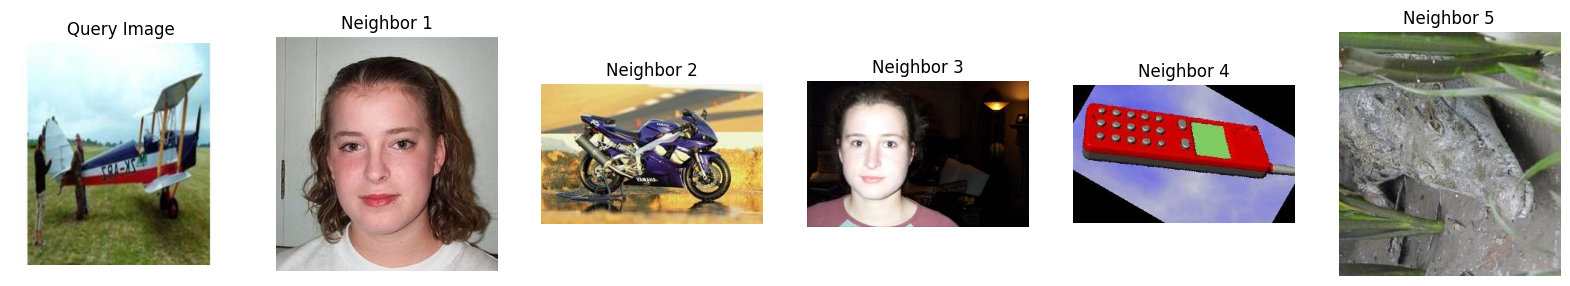

In [24]:
# Mostrar la imagen de consulta y las imágenes de los vecinos más cercanos
def display_images(query_image, neighbor_indices, image_paths):
    plt.figure(figsize=(20, 4))
    plt.subplot(1, 6, 1)
    plt.imshow(query_image)
    plt.title("Query Image")
    plt.axis('off')
    
    for i, idx in enumerate(neighbor_indices[0]):
        neighbor_image = Image.open(image_paths[idx])
        plt.subplot(1, 6, i+2)
        plt.imshow(neighbor_image)
        plt.title(f"Neighbor {i+1}")
        plt.axis('off')
    
    plt.show()

display_images(query_image_display, indices, train_paths)